# Fine-tune GPT-2 Vietnamese on Custom Dataset

This notebook demonstrates how to fine-tune the `NlpHUST/gpt2-vietnamese` model on a small sample of the `VTSNLP/vietnamese_curated_dataset`, save the model and tokenizer, and test the fine-tuned model.

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install --upgrade datasets
!pip uninstall transformers -y
!pip install transformers==4.51.3
from transformers import TrainingArguments

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import os

In [ ]:
from datasets import load_dataset

In [ ]:
MODEL_NAME = "NlpHUST/gpt2-vietnamese"
DATASET_NAME = "VTSNLP/vietnamese_curated_dataset"
OUTPUT_TEMP_DIR = "/content/temp/checkpoint"
OUTPUT_DIR = "/content/drive/MyDrive/model/GPT-2-124m"

# Load dataset in streaming mode
dataset = load_dataset(DATASET_NAME, streaming=True)

Resolving data files:   0%|          | 0/132 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/132 [00:00<?, ?it/s]

In [ ]:
NUM_SAMPLES = int(20000) # Taking a small fixed number of samples, adjust as needed

if "train" in dataset:
    # For IterableDataset, we use take() to get a fixed number of samples
    train_dataset = dataset["train"].take(NUM_SAMPLES).shuffle(seed=42)
else:
    # If no "train" split, apply to the main dataset (assuming it's also iterable)
    train_dataset = dataset.take(NUM_SAMPLES).shuffle(seed=42)

In [ ]:
if "validation" in dataset:
    NUM_EVAL_SAMPLES = max(1, int(NUM_SAMPLES * 0.1)) # Take 10% of train samples for eval, minimum 1
    eval_dataset = dataset["validation"].take(NUM_EVAL_SAMPLES).shuffle(seed=42)
else:
    print("No 'validation' split found. Creating train/eval split from the main dataset (assuming 'train' exists).")
    # We need to take samples from an existing split to create new train/eval splits
    # Let's assume 'train' split exists and use it.
    if "train" in dataset:
        source_dataset = dataset["train"]
        TOTAL_SAMPLES_FOR_SPLIT = int(NUM_SAMPLES * 1.1) # Take slightly more samples to split
        # Take samples from the source dataset split. Convert to list to split.
        # Note: This consumes the iterator up to TOTAL_SAMPLES_FOR_SPLIT
        all_samples = list(source_dataset.take(TOTAL_SAMPLES_FOR_SPLIT).shuffle(seed=42))

        # Now split the list
        split_index = int(NUM_SAMPLES * 0.1) # 10% for eval
        # Ensure the split index is within the bounds of collected samples
        split_index = min(split_index, len(all_samples))

        eval_dataset_list = all_samples[:split_index]
        train_dataset_list = all_samples[split_index:]

        from datasets import Dataset
        train_dataset = Dataset.from_list(train_dataset_list)
        eval_dataset = Dataset.from_list(eval_dataset_list)

        print(f"Created train dataset with {len(train_dataset)} samples and eval dataset with {len(eval_dataset)} samples.")
    else:
        print("Error: No 'train' or 'validation' split found in the dataset.")
        # You might want to raise an error or handle this case appropriately
        # For now, we'll just print an error message.
        train_dataset = None
        eval_dataset = None

No 'validation' split found. Creating train/eval split from the main dataset (assuming 'train' exists).
Created train dataset with 20000 samples and eval dataset with 2000 samples.


In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_NAME)
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)

# Ensure we have a pad token
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512, padding="max_length")

train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=[c for c in train_dataset.column_names if c != "text"])
eval_dataset  = eval_dataset.map(tokenize_function, batched=True, remove_columns=[c for c in eval_dataset.column_names  if c != "text"])

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
def print_trainable_parameters(model):
    """Prints the number and percentage of trainable parameters in the model."""
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_param = sum(p.numel() for p in model.parameters())
    non_trainable_params = all_param - trainable_params
    print(f"trainable params: {trainable_params:,} || non-trainable params: {non_trainable_params:,} || total params: {all_param:,}")
    if all_param > 0:
        print(f"percentage of trainable parameters: {100 * trainable_params / all_param:.2f}%")
    else:
        print("Model has no parameters.")

print_trainable_parameters(model)


trainable params: 124,441,344 || non-trainable params: 0 || total params: 124,441,344
percentage of trainable parameters: 100.00%


In [ ]:
def count_total_tokens(dataset, input_key="input_ids"):
    """Count the total number of tokens in a HuggingFace dataset."""
    if dataset is None:
        print("Dataset is None.")
        return 0
    total_tokens = 0
    for i in range(len(dataset)):
        item = dataset[i]
        if input_key in item:
            total_tokens += len(item[input_key])
        else:
            print(f"Warning: '{input_key}' not found in item {i}.")
    print(f"Total tokens in dataset: {total_tokens}")
    return total_tokens

# Count tokens in train and eval datasets
count_total_tokens(train_dataset)
count_total_tokens(eval_dataset)

Total tokens in dataset: 10240000
Total tokens in dataset: 1024000


1024000

In [ ]:
def inspect_tokenized_dataset(dataset, name="dataset"):
    print(f"--- {name} ---")
    if dataset is None:
        print("Dataset is None.")
        return
    # Show available columns
    print("Columns:", dataset.column_names)
    # Show number of samples (if possible)
    try:
        print("Number of samples:", len(dataset))
    except Exception as e:
        print("Could not determine dataset length:", e)
    # Show a sample entry
    try:
        print("Sample entry:", dataset[0])
    except Exception as e:
        print("Could not display sample entry:", e)
    print()

inspect_tokenized_dataset(train_dataset, "Train Dataset")
inspect_tokenized_dataset(eval_dataset, "Eval Dataset")

--- Train Dataset ---
Columns: ['text', 'input_ids', 'attention_mask']
Number of samples: 20000
Sample entry: {'text': 'Tổng Giám đốc PMU Đường sắt trần tình chuyện đã công chức vẫn \'đóng vai\'... viên chức\nNếu diễn biến đúng như những gì dư luận đã đồn đoán, thì chưa đầy 2 tuần nữa, Tổng Giám đốc Ban quản lý dự án (PMU) Đường sắt Lê Kim Thành sẽ chính thức thành Cục trưởng Quản lý Xây dựng & Chất lượng công trình giao thông (QLXD&CLCTGT) - một chiếc ghế đầy quyền lực mà nhiều người mơ ước.\nTổng Giám đốc Lê Kim Thành nói PMU Đường sắt nhiều đổi thay từ khi ông về đây quản lý\nÔng Thành sẽ nói lời tạm biệt "Ban A" này khi Dự án Đường sắt đô thi trên cao Cát Linh - Hà Đông (Hà Nội) đang dở dang giai đoạn cuối - để tới nơi mới đầy hứa hẹn và triển vọng hơn.\nNhiều năm không "ăn" lương ngân sách\nTrong một lần trả lời PLVN mới đây, ông Thành tự tin xác nhận, Bộ GTVT đang chuẩn bị làm quy trình để bổ nhiệm ông vào một vị trí khác.\nTuy nhiên, như đã thông tin, trước đó Bộ GTVT đã ban hàn

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
from transformers import TrainerCallback

class SaveLastEpochsCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, model=None, **kwargs):
        if state.epoch in [24.0, 25.0]:  # epoch tính theo float
            ckpt_path = f"{args.output_dir}/custom_checkpoint_epoch_{int(state.epoch)}"
            model.save_pretrained(ckpt_path)
            print(f"✅ Saved model manually at epoch {int(state.epoch)} → {ckpt_path}")
        return control

In [ ]:
from transformers import TrainingArguments, Trainer, EvalPrediction

training_args = TrainingArguments(
    output_dir=OUTPUT_TEMP_DIR,
    overwrite_output_dir=True,
    num_train_epochs=50,
    per_device_train_batch_size=48,
    per_device_eval_batch_size=96,
    save_total_limit=2,
    learning_rate=5e-5,
    fp16=True,
    load_best_model_at_end=True,
    prediction_loss_only=False,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="epoch",
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

In [ ]:
from transformers import EarlyStoppingCallback

callbacks = [SaveLastEpochsCallback(), EarlyStoppingCallback(early_stopping_patience=15)]


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    callbacks=callbacks
)


In [ ]:
trainer.train()
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Model fine-tuned and saved at {OUTPUT_DIR}")

Epoch,Training Loss,Validation Loss
1,2.549900,2.597576
2,2.515700,2.581277
3,2.489000,2.570811
4,2.464900,2.564882
5,2.443100,2.559831
6,2.423000,2.556858
7,2.403700,2.554256
8,2.385400,2.553545
9,2.368200,2.553513
10,2.351100,2.553790


✅ Saved model manually at epoch 24 → /content/temp/checkpoint/custom_checkpoint_epoch_24


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model fine-tuned and saved at /content/drive/MyDrive/model/GPT-2-124m


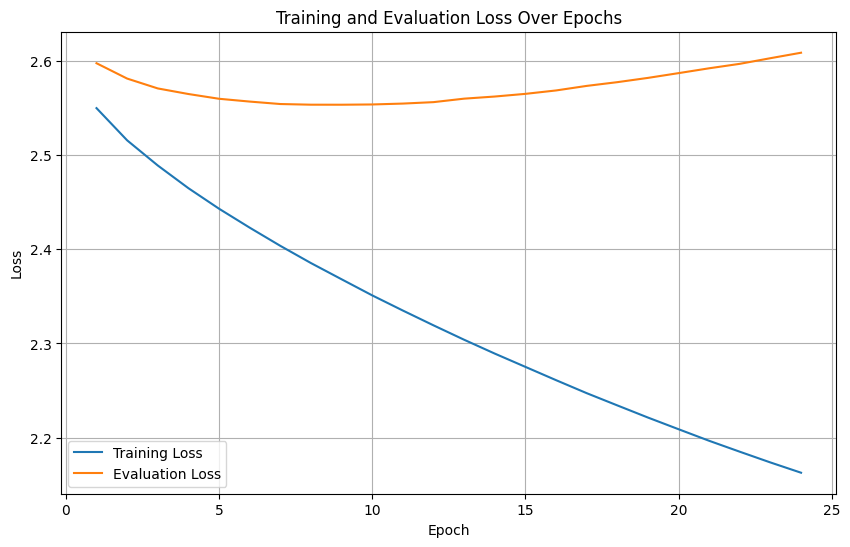

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# Get the logs
logs = trainer.state.log_history

# Convert to a pandas DataFrame for easier plotting
df = pd.DataFrame(logs)

# Filter out steps that are not epochs (like initial logging)
df_epochs = df[df['epoch'].notna() & (df['loss'].notna() | df['eval_loss'].notna())]

plt.figure(figsize=(10, 6))

# Plot training loss if available and not all values are NaN
if 'loss' in df_epochs.columns and not df_epochs['loss'].isnull().all():
    plt.plot(df_epochs['epoch'][df_epochs['loss'].notna()], df_epochs['loss'][df_epochs['loss'].notna()], label='Training Loss')

# Plot evaluation loss if available and not all values are NaN
if 'eval_loss' in df_epochs.columns and not df_epochs['eval_loss'].isnull().all():
    plt.plot(df_epochs['epoch'][df_epochs['eval_loss'].notna()], df_epochs['eval_loss'][df_epochs['eval_loss'].notna()], label='Evaluation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def load_model_and_tokenizer(model_dir):
    """Load fine-tuned model and tokenizer from the given directory."""
    tok = GPT2TokenizerFast.from_pretrained(model_dir)
    mdl = GPT2LMHeadModel.from_pretrained(model_dir)
    mdl.eval()
    return mdl, tok


def generate_text(prompt, model, tokenizer, max_length=50, num_return_sequences=1):
    """Generate continuations for a given prompt."""
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(
        inputs,
        max_length=max_length,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        num_return_sequences=num_return_sequences,
        pad_token_id=tokenizer.pad_token_id
    )
    return [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]

if __name__ == "__main__":
    # Example usage after training
    model, tokenizer = load_model_and_tokenizer(OUTPUT_DIR)
    test_prompts = ["Trường đại học là một nơi"]
    for prompt in test_prompts:
        print(f"Prompt: {prompt}")
        generations = generate_text(prompt, model, tokenizer, max_length=100, num_return_sequences=2)
        for i, gen in enumerate(generations, start=1):
            print(f" Generation {i}: {gen}\n")

Prompt: Trường đại học là một nơi
 Generation 1: Trường đại học là một nơi đào tạo đa ngành: Kinh tế, Kế toán, Ngôn ngữ Anh, Tài chính ngân hàng, Truyền thông và quản trị kinh doanh, Công nghệ thông tin và truyền thông.
Các trường đại học được công nhận trên toàn thế giới.
Các chương trình đào tạo phổ biến tại Đại học Oxford
Các chuyên ngành đào tạo có thể được cung cấp tại bất kỳ khoa nào tại Đại học Oxford.
Mục lục
1 Giáo dục đại học tại Đại học

 Generation 2: Trường đại học là một nơi không thể thiếu để các sinh viên có được kiến thức về kinh tế, xã hội, giáo dục, y dược. Đồng thời đây cũng là nơi các cán bộ giảng dạy của trường có cơ hội nâng cao chuyên môn, đáp ứng yêu cầu đào tạo cán bộ giảng dạy đại học của trường trong thời đại công nghiệp 4.0
Trường đại học đào tạo một khóa học chính trị, quản lý, tổng hợp, nghiên cứu khoa học, sư phạm, văn



In [ ]:
def predict_next_full_word(prompt, model, tokenizer, top_k=50, top_p=0.95, max_attempts=10):
    model.eval()
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    input_ids = inputs[0]
    input_len = input_ids.shape[0]

    # Loop token until 1 completed word
    for _ in range(max_attempts):
        outputs = model.generate(
            inputs,
            max_new_tokens=3,  # new max token =3
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            num_return_sequences=1,
            pad_token_id=tokenizer.pad_token_id,
        )

        generated_ids = outputs[0][input_len:]
        decoded = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

        # Check if the word is completed
        words = decoded.split()
        if len(words) >= 1:
            return words[0]  # Return first word

    return ""  # If not generating anything after max_attempts


In [ ]:
if __name__ == "__main__":
    model, tokenizer = load_model_and_tokenizer(OUTPUT_DIR)
    prompt = "Trường đại học là một nơi"
    next_word = predict_next_full_word(prompt, model, tokenizer)
    print(f"Prompt: {prompt}")
    print(f"Next word prediction: {next_word}")


Prompt: Trường đại học là một nơi
Next word prediction: tốt
